# ⏲ Numerical simulations of particle under continuous measurement and feedback

## Mount drive to save images

In [62]:
# from google.colab import drive
# drive.mount('/content/drive')

## Change directory

In [63]:
# %cd "/content/drive/MyDrive/Continuous_Measurement_Feedback"

## Libraries

In [64]:
import numpy as np

np.random.seed(2)
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.integrate import solve_ivp
import os
from matplotlib import rc, rcParams

rc("animation", html="jshtml")
import matplotlib.animation as animation

plt.rcParams["font.size"] = 22
plt.rcParams["axes.linewidth"] = 2
rcParams.update({"figure.autolayout": True})

## Helper function to prevent overwriting existing files

In [65]:
def uniquify(path):
    filename, extension = os.path.splitext(path)
    counter = 1
    while os.path.exists(path):
        path = filename + " (" + str(counter) + ")" + extension
        counter += 1
    return path

In [66]:
# create output directory if it doesn't exist
if not os.path.exists("./output"):
    os.makedirs("./output")

In [67]:
# Example
fname = uniquify("./output/animation.gif")
print("Saving at:", fname)

Saving at: ./output/animation.gif


## Particle class

In [68]:
class Particle:
    """
    Create a "particle" with Guassian probablity distribution, initial positoin x0,
    momentum p0 and second order variances <(x-<x>)**2> = sx0**2,
    <(p-<p>)**2> = sp0**2 and  <{x-<x>, p - <p>}> = R0, where sp0**2 = (1+R0**2)/4/sx0**2.

    The "spacial dimension" x is taken to be the measured observable with conjugate
    momentum p. x and p are assumed unitless so that all computations are unitless.

    Spacial resolution is given by dx with a window size of [-xmax, xmax].

    Error tolerance is given by tol.

    """

    def __init__(
        self, x0=1, p0=0, sx0=1 / np.sqrt(2), R0=0.0, dx=0.1, xmax=10, tol=10 ** (-2)
    ):

        self.dx = dx
        self.xmax = xmax
        self.x = np.arange(0, int(xmax / dx) * 2 + 1) * dx - xmax

        self.x0 = x0
        self.p0 = p0

        self.sx0 = sx0
        self.R0 = R0
        self.sp0 = np.sqrt((1 + self.R0**2) / 4 / (self.sx0) ** 2)

        self.tol = tol

        ####################

        self.psi = np.exp(
            1j * p0 * (self.x - self.x0)
            - (1 - 1j * R0) * (self.x - self.x0) ** 2 / ((2 * self.sx0) ** 2)
        )
        self.psi = self.psi / self.norm(self.psi)

        self.expx = self.get_expx(self.psi)
        self.expp = self.get_expp(self.psi)
        self.varx = self.get_varx(self.psi, self.expx)
        self.varp = self.get_varp(self.psi, self.expp)
        self.expR = self.get_expR(self.psi, self.expx, self.expp)

        # Errors
        self.error = [
            abs(self.expx - self.x0),
            abs(self.varx - self.sx0**2),
            abs(self.expp - self.p0),
            abs(self.varp - self.sp0**2),
            abs(self.expR - self.R0),
        ]

        if abs(self.x0) > self.xmax or abs(self.x0 + 2 * self.sx0) > self.xmax:
            raise Exception("x0 outside of window")

        if abs(self.expx - self.x0) > tol:
            raise Exception("abs(expx-x0) > tol")

        if abs(self.expp - self.p0) > tol:
            print(abs(self.expp - self.p0))
            raise Exception("abs(expp-p0) > tol")

        if abs(self.varx - self.sx0**2) > tol:
            raise Exception("abs(varx-sx0**2) > tol")

        if abs(self.varp - self.sp0**2) > tol:
            raise Exception("abs(varp-sp0**2) > tol")

    def get_findif(self, f, order):
        """
        Get the first or second derivative of f according to the finite difference
        formula with circular boundry conditions.

        Parameters
        ==========
        f   complex nparray
            Numerical values of a function at points self.x.
        order int
            1 for first derivative, 2 for second derivative.

        Return
        =========
        ans/self.dx**order    complex ndarray of shape f
            First or second order deriviative of f.

        Example
        ========
        # First derivative of sin(x)
        ans = self.get_findif(np.sin(self.x), order = 1)
        """
        if order == 1:
            c = [0.5, 0, -0.5]
        if order == 2:
            c = [1, -2, 1]

        ans = np.zeros(f.size, dtype=complex)
        ans[0] = c[2] * f[-1] + c[1] * f[0] + c[0] * f[1]
        ans[1:-1] = c[2] * f[:-2] + c[1] * f[1:-1] + c[0] * f[2:]
        ans[-1] = c[2] * f[-2] + c[1] * f[-1] + c[0] * f[0]

        return ans / self.dx**order

    def get_expx(self, phi):
        """
        Get expectation value <x> w.r.t. phi.

        Parameters
        ==========
        phi   complex nparray
              Numerical values at self.x, assuming that sum(abs(phi)**2) = 1.
        Returns
        =========
        np.dot(self.x, abs(phi)**2)  float
              Expectation value x with respect to phi.

        Example
        =========
        # Compute <x>, should be equal to x0 if psi has not been updated.
        exp_x = self.get_expx(self.psi)
        """
        return np.dot(self.x, abs(phi) ** 2)

    def get_expp(self, phi):
        """
        Get expectation value <p> w.r.t. phi.

        Parameters
        ==========
        phi   complex nparray
              Numerical values at self.x, assuming that sum(abs(phi)**2) = 1.
        Returns
        =========
        np.real(p)  float
              Expectation value x with respect to phi.

        Example
        =========
        # Compute <p>, should be equal to p0 if psi has not been updated.
        exp_p = self.get_expp(self.psi)
        """
        p = -1j * np.dot(np.conj(phi), self.get_findif(phi, 1))
        if np.imag(p) > self.tol:
            print(p)
            raise Exception("imag(expp) > tol")

        return np.real(p)

    def get_expR(self, phi, expx_phi, expp_phi):
        """
        Get expectation value <{x-<x>,p-<p>}>.

        Parameters
        ==========
        phi   complex nparray
              Numerical values at self.x, assuming that sum(abs(phi)**2) = 1.
        expp_phi float
              expectation values of p w.r.t. phi.
        expp_xhi float
              expectation values of x w.r.t. phi.

        Returns
        =========
        np.real(R)  float
              Expectation value <{x-<x>,p-<p>}> with respect to phi.

        Example
        =========
        # Compute  <{x-<x>,p-<p>}>, should be equal to R0 if psi has not been updated.
        exp_R = self.get_expR(self.psi)
        """
        R = -1j * (2 * np.dot(np.conj(phi), self.x * self.get_findif(phi, 1)) + 1)
        if np.imag(R) > self.tol:
            print(R)
            raise Exception("imag(R) > tol")

        return np.real(R) - 2 * expx_phi * expp_phi

    def get_varx(self, phi, expx_phi):
        """
        Get expectation value <(x-<x>)**2>.

        Parameters
        ==========
        phi   complex nparray
              Numerical values at self.x, assuming that sum(abs(phi)**2) = 1.
        Returns
        =========
        np.dot((self.x-expx_phi)**2,abs(phi)**2)  float
              Expectation value <(x-<x>)**2> with respect to phi.
        expp_xhi float
              expectation values of x w.r.t. phi.

        Example
        =========
        # Compute  <(x-<x>)**2>, should be equal to sx0**2 if psi has not been updated.
        var_x = self.get_varx(self.psi)
        """
        return np.dot((self.x - expx_phi) ** 2, abs(phi) ** 2)

    def get_varp(self, phi, expp_phi):
        """
        Get expectation value <(p-<p>)**2>.

        Parameters
        ==========
        phi   complex nparray
              Numerical values at self.x, assuming that sum(abs(phi)**2) = 1.
        Returns
        =========
        np.real(vp)  float
              Expectation value <(x-<x>)**2> with respect to phi.
        expp_phi float
              expectation values of p w.r.t. phi

        Example
        =========
        # Compute  <(p-<p>)**2>, should be equal to sp0**2 if psi has not been updated.
        var_p = self.get_varp(self.psi)
        """
        vp = 2j * np.dot(np.conj(phi), self.get_findif(phi, 1)) * expp_phi
        vp += expp_phi**2
        vp += -np.dot(np.conj(phi), self.get_findif(phi, 2))

        if np.imag(vp) > self.tol:
            print(vp)
            raise Exception("imag(varp) > tol")
        return np.real(vp)

    def norm(self, phi):
        """
        Compute the norm of phi.

        Parameters
        ==========
        phi   complex nparray
              Numerical values at self.x, assuming that sum(abs(phi)**2) = 1.
        Returns
        =========
        np.sqrt(np.dot(np.conj(phi),phi)) float
              Inner product phi*'(phi)
        """
        return np.sqrt(np.dot(np.conj(phi), phi))

## Time evolution class

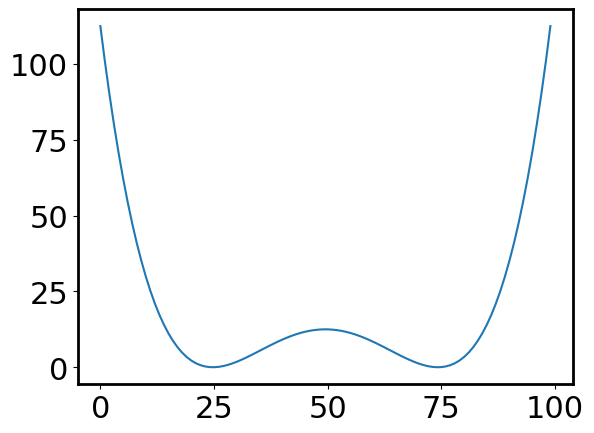

In [69]:
# @title
x = np.linspace(-10, 10, 100)
plt.plot(-(x**2) + 1 / 50 * x**4 + 25 / 2)

In [70]:
class evolvingParticle(Particle):
    """
    Evolve particle in time.

    Unitless version of measurement strength is given by kappa.
    Measurement and feedback can be toggles on and off.
    If measurment is False, feeback will automatically set to false.
    Generator of feeback is given by F = c*x+d*p, where x corresponds to
    the measured observable.

    Evolution is computed using second-order weak scheme [Breuer, Heinz-Peter,
    and Francesco Petruccione. The theory of open quantum systems. Oxford
    University Press on Demand, 2002.].

    Time step is given by dt with end time given by tmax. A number of steps is
    waited before recording results, given by N_wait.

    Hamiltonian_type specifies if the particle is in a harmoic potential or is
    free.

    Example
    =======
    myParticle = evolvingParticle()
    myParticle.plot_results()

    """

    def __init__(
        self,
        x0=0,
        p0=1,
        sx0=1 / np.sqrt(2),
        R0=0.5,
        dx=0.1,
        xmax=10,
        kappa=1,
        tol=10 ** (-3),
        measurement=True,
        feedback=False,
        feedback_type=None,
        c=1,
        d=0,
        tmax=5 * 2 * np.pi,
        dt=10**-3,
        N_wait=100,
        Hamiltonian_type="Harmonic",
    ):

        # evolvingParticle inherits all methods and variables from Particle
        super().__init__(x0=x0, p0=p0, sx0=sx0, R0=R0, dx=dx, xmax=xmax, tol=tol)

        self.tmax = tmax
        self.dt = dt
        self.N_wait = N_wait

        if (
            Hamiltonian_type == "Harmonic"
            or Hamiltonian_type == "Free"
            or Hamiltonian_type == "DoubleWell"
        ):
            self.Hamiltonian_type = Hamiltonian_type
        else:
            raise Exception("Hamiltonian_type is either Harmonic or Free")

        if self.Hamiltonian_type == "Free":
            print("Note that the measured observable x is assume to be position")

        self.kappa = kappa

        self.measurement = measurement
        self.feedback = feedback
        self.feedback_type = feedback_type

        if self.measurement == False and self.feedback == True:
            raise Exception("No feedback without measurement")

        # Find stable values for
        # - measurement, no feedback Harmonic and Free
        # - measurement and feedback Free
        if self.measurement == True and self.feedback == True:
            if self.Hamiltonian_type == "Harmonic":
                self.varx_inf = (
                    np.sqrt(-1 + np.sqrt(1 + self.kappa**2)) / np.sqrt(2) / self.kappa
                )
                self.varp_inf = (
                    np.sqrt(1 + self.kappa**2)
                    * np.sqrt(-1 + np.sqrt(1 + self.kappa**2))
                    / np.sqrt(2)
                    / self.kappa
                )
                self.expr_inf = (-1 + np.sqrt(1 + self.kappa**2)) / self.kappa
                self.E_inf = 0.5 * (self.varx_inf + self.varp_inf)
            elif self.Hamiltonian_type == "Free":
                self.varx_inf = 1 / np.sqrt(2 * kappa)
                self.varp_inf = np.sqrt(kappa / 2)
                self.expr_inf = 1
                self.E_inf = 0.5 * (self.varp_inf)
            elif self.Hamiltonian_type == "DoubleWell":
                self.varx_inf = (
                    np.sqrt(-1 + np.sqrt(1 + self.kappa**2)) / np.sqrt(2) / self.kappa
                )
                self.varp_inf = (
                    np.sqrt(1 + self.kappa**2)
                    * np.sqrt(-1 + np.sqrt(1 + self.kappa**2))
                    / np.sqrt(2)
                    / self.kappa
                )
                self.expr_inf = (-1 + np.sqrt(1 + self.kappa**2)) / self.kappa
                self.E_inf = 0.5 * (self.varx_inf + self.varp_inf)
            else:
                self.varx_inf = None
                self.varp_inf = None
                self.expr_inf = None
                self.E_inf = None
        else:
            self.varx_inf = None
            self.varp_inf = None
            self.expr_inf = None
            self.E_inf = None

        if self.feedback == False:
            print("Feedback coefficients c and d set to zero.")
            self.c = 0
            self.d = 0
        elif (
            self.feedback == True
            and self.feedback_type == "Cooling"
            and self.expr_inf != None
        ):
            print("Feedback coefficients c and d set to values for cooling.")
            self.c = kappa * self.expr_inf
            self.d = -2 * kappa * self.varx_inf
        else:
            self.c = c
            self.d = d

        self.E0 = np.dot(np.conj(self.psi), self.Hamiltonian(self.psi))

        self.T = (
            np.arange(0, int(np.floor(int(self.tmax / self.dt) / self.N_wait) + 1))
            * self.dt
            * self.N_wait
            / 2
            / np.pi
        )
        self.dW = np.random.normal(
            loc=0.0, scale=1.0, size=(int(np.ceil(self.tmax / self.dt)),)
        ) * np.sqrt(self.dt)

        if self.Hamiltonian_type == "Hormonic" or self.Hamiltonian_type == "Free":
            (
                self.X_TH,
                self.P_TH,
                self.E_TH,
                self.VAR_X_TH,
                self.VAR_P_TH,
                self.EXP_R_TH,
                self.T_TH,
            ) = self.get_theoretical()
        else:
            self.X_TH = None
            self.P_TH = None
            self.E_TH = None
            self.VAR_X_TH = None
            self.VAR_P_TH = None
            self.EXP_R_TH = None
            self.T_TH = None

        self.PSI, self.EXP_X, self.EXP_P, self.E, self.VAR_X, self.VAR_P, self.EXP_R = (
            self.second_order_weak_scheme()
        )

    def update_psi(self, phi):
        """
        Update Particle with new state phi

        Parameters
        ==========
        phi complex nparray
          New state

        Returns
        =========
        None
        """
        self.psi = phi / self.norm(phi)

        self.expx = self.get_expx(self.psi)
        self.expp = self.get_expp(self.psi)
        self.varx = self.get_varx(self.psi, self.expx)
        self.varp = self.get_varp(self.psi, self.expp)
        self.expR = self.get_expR(self.psi, self.expx, self.expp)

        return None

    def Hamiltonian(self, phi):
        """
        Compute Hamiltonian, H|phi>.

        Paramters
        =========
        phi   complex nparray

        Returns
        ========
        H     complex nparray
              H|phi>
        """
        if self.Hamiltonian_type == "Harmonic":
            H = 0.5 * (-self.get_findif(phi, 2) + self.x**2 * phi)
        elif self.Hamiltonian_type == "Free":
            H = 0.5 * (-self.get_findif(phi, 2))
        elif self.Hamiltonian_type == "DoubleWell":
            H = 0.5 * (
                -self.get_findif(phi, 2) - self.x**2 * phi + 1 / 50 * self.x**4 * phi
            )
        else:
            raise Exception("Hamiltonian_type is not known")
        return H

    def Measurement(self, phi, expx_phi):
        """
        Compute the measurment dependant parts of the master equation

        Parameters
        ==========
        phi   complex nparray
              state
        expx_phi  float
              expectation values of x w.r.t. phi

        Returns
        =========
        (self.x-expx_phi)**2*phi    complex nparray

        """
        return (self.x - expx_phi) ** 2 * phi

    def Feedback(self, phi, expx_phi):
        """
        Compute the feedback dependant parts of the master equation

        Parameters
        ==========
        phi   complex nparray
              state
        expx_phi  float
              expectation values of x w.r.t. phi

        Returns
        =========
        -1/4/self.kappa*F_1 -1j/2*F_2    complex nparray

        """
        F_1 = (
            self.c**2 * self.x**2 * phi
            - self.d**2 * self.get_findif(phi, 2)
            - 1j * self.c * self.d * (2 * self.x * self.get_findif(phi, 1) + phi)
        )

        F_2 = (
            self.c * self.x**2 * phi
            - 1j * self.d * (self.x * self.get_findif(phi, 1) + phi)
            + expx_phi * (self.c * self.x * phi - 1j * self.d * self.get_findif(phi, 1))
        )

        return -1 / 4 / self.kappa * F_1 - 1j / 2 * F_2

    def Stochastic(self, phi, expx_phi):
        """
        Compute the stochastic parts of the master equation

        Parameters
        ==========
        phi   complex nparray
              state
        expx_phi  float
              expectation values of x w.r.t. phi

        Returns
        =========
        S    complex nparray

        """
        if self.feedback == True:
            F = self.c * self.x * phi - 1j * self.d * self.get_findif(phi, 1)
        else:
            F = 0
        S = (
            np.sqrt(self.kappa / 2) * (self.x - expx_phi) * phi
            - 1j / np.sqrt(self.kappa * 2) * F
        )

        return S

    def get_D(self, phi, expx_phi):
        """
        Compute the two terms of the master equation proportional to dt and dW.

        Parameters
        ==========
        phi   complex nparray
              state
        expx_phi  float
              expectation values of x w.r.t. phi

        Returns
        =========
        D1    complex nparray
              Term proportional to dt
        D2    complex nparray
              Term proportional to dW

        """
        H = self.Hamiltonian(phi)

        if self.measurement == True:
            M = self.Measurement(phi, expx_phi)
        else:
            M = 0

        if self.feedback == True:
            F = self.Feedback(phi, expx_phi)
        else:
            F = 0

        D1 = -1j * H - self.kappa / 4 * M + F

        if self.measurement == True:
            D2 = self.Stochastic(phi, expx_phi)
        else:
            D2 = 0

        return D1, D2

    def step_time(self, dW):
        """
        Take one step in time and update Particle.

        Parameters
        ==========
        dW    float
              Stochastic incriment

        Returns
        =========
        None

        """
        D1, D2 = self.get_D(self.psi, self.expx)

        psi_tilde = self.psi + D1 * self.dt + D2 * dW
        psi_tilde = psi_tilde / self.norm(psi_tilde)

        expx_tilde = self.get_expx(psi_tilde)
        D1_tilde, D2_tilde = self.get_D(psi_tilde, expx_tilde)

        psi_plus = self.psi + D1 * self.dt + D2 * np.sqrt(self.dt)
        psi_plus = psi_plus / self.norm(psi_plus)

        expx_plus = self.get_expx(psi_plus)
        D1_plus, D2_plus = self.get_D(psi_plus, expx_plus)

        psi_minus = self.psi + D1 * self.dt - D2 * np.sqrt(self.dt)
        psi_minus = psi_minus / self.norm(psi_minus)

        expx_minus = self.get_expx(psi_minus)
        D1_minus, D2_minus = self.get_D(psi_minus, expx_minus)

        self.update_psi(
            self.psi
            + 0.5 * (D1_tilde + D1) * self.dt
            + 0.25 * (D2_plus + D2_minus + 2 * D2) * dW
            + 0.25 * (D2_plus - D2_minus) * (dW**2 - self.dt) / np.sqrt(self.dt)
        )

        return None

    def coupled_ODE(self, t, w, k):
        """
        Defines the differential equations for the coupled system that governs
        the second order variances

        Parameters
        ===========
        w   list of floats, length 3
            vector of the state variables w = [x,y,z]
        t   float
            time
        k   float
            parameter

        Returns
        =========
        f   list of floats, length 3
            Coupled differential equation at w = [x,y,z] and t with scaling
            parameter k
        """

        # Create f = (x',y',z'):
        if self.Hamiltonian_type == "Harmonic":
            f = [
                -2 * k * w[0] ** 2 + w[2],
                k / 2 * (1 - w[2] ** 2) - w[2],
                2 * (w[1] - w[0]) - 2 * k * w[0] * w[2],
            ]
        elif self.Hamiltonian_type == "Free":
            f = [
                -2 * k * w[0] ** 2 + w[2],
                k / 2 * (1 - w[2] ** 2),
                2 * w[1] - 2 * k * w[0] * w[2],
            ]

        return f

    def get_theoretical(self):
        """
        Get theoretical values for the second order variances

        Parameters
        ==========

        Returns
        =========
        X, Y, E, varx, vary, r, T_TH
          lists of theoretical values of x, p, energy, variance of x and p,
          R, and times used.
        """
        if self.measurement == True:
            wsol = solve_ivp(
                fun=self.coupled_ODE,
                t_span=[0, self.tmax],
                y0=[self.sx0**2, self.sp0**2, self.R0],
                method="DOP853",
                args=(self.kappa,),
                max_step=self.dt,
            )  # *N_wait
        else:
            wsol = solve_ivp(
                fun=self.coupled_ODE,
                t_span=[0, self.tmax],
                y0=[self.sx0**2, self.sp0**2, self.R0],
                method="DOP853",
                args=(0,),
                max_step=self.dt,
            )  # *N_wait

        varx, vary, r = wsol.y[0], wsol.y[1], wsol.y[2]
        T_TH = wsol.t / 2 / np.pi

        X = [self.x0]
        Y = [self.p0]
        E = [self.E0]

        X_i = X[-1]
        Y_i = Y[-1]

        for dt_i, dW_i, varx_i, r_i in tqdm(
            zip(wsol.t[1:] - wsol.t[0:-1], self.dW, varx, r), desc="Theorectical"
        ):

            if self.measurement == True:

                if self.Hamiltonian_type == "Harmonic":
                    dX = Y_i * dt_i
                    dY = -1 * X_i * dt_i
                    dE = (
                        self.kappa
                        / 4
                        * (1 - (self.c / self.kappa) ** 2 - (self.d / self.kappa) ** 2)
                        - 0.5 * self.c * (r_i - self.c / self.kappa + 2 * X_i * Y_i)
                        + self.d * (varx_i + self.d / self.kappa / 2 + X_i**2)
                    ) * dt_i
                    dE += (
                        np.sqrt(self.kappa / 2)
                        * (
                            2 * X_i * (varx_i + self.d / 2 / self.kappa)
                            + Y_i * (r_i - self.c / self.kappa)
                        )
                        * dW_i
                    )
                elif self.Hamiltonian_type == "Free":
                    dX = Y_i * dt_i
                    dY = 0
                    dE = (
                        self.kappa / 4 * (1 - (self.c / self.kappa) ** 2)
                        - 0.5 * self.c * (r_i - self.c / self.kappa + 2 * X_i * Y_i)
                    ) * dt_i
                    dE += (
                        np.sqrt(self.kappa / 2)
                        * (2 * X_i * varx_i + Y_i * (r_i - self.c / self.kappa))
                        * dW_i
                    )

                dX += (self.d * X_i) * dt_i + np.sqrt(2 * self.kappa) * (
                    varx_i + self.d / 2 / self.kappa
                ) * dW_i
                dY += (
                    -self.c * X_i * dt_i
                    + np.sqrt(self.kappa / 2) * (r_i - self.c / self.kappa) * dW_i
                )

                X.append(X_i + dX)
                Y.append(Y_i + dY)
                E.append(E[-1] + dE)

                X_i = X[-1]
                Y_i = Y[-1]

            else:
                dX = (Y_i + self.d * X_i) * dt_i
                X.append(X[-1] + dX)

                dY = -(1 + self.c) * X_i * dt_i
                Y.append(Y_i + dY)

                dE = 0
                E.append(E[-1] + dE)

                X_i = X[-1]
                Y_i = Y[-1]

        return X, Y, E, varx, vary, r, T_TH

    def second_order_weak_scheme(self):
        """
        Impliment the second order weak scheme. Store and return values of key
        quantities over time.

        """
        PSI = [self.psi]

        EXP_X = [self.expx]
        EXP_P = [self.expp]

        VAR_X = [self.varx]
        VAR_P = [self.varp]
        R = [self.expR]
        E = [self.E0]

        count = 0
        for dW_i in tqdm(self.dW, desc="Second order weak scheme"):
            self.step_time(dW_i)
            count += 1
            if count % self.N_wait == 0:

                PSI.append(self.psi)
                E.append(np.dot(np.conj(self.psi), self.Hamiltonian(self.psi)))
                EXP_X.append(self.expx)
                EXP_P.append(self.expp)
                VAR_X.append(self.varx)
                VAR_P.append(self.varp)
                R.append(self.expR)

        return PSI, EXP_X, EXP_P, E, VAR_X, VAR_P, R

    def plot_results(self, save=False):
        """
        Plot results.

        Parameters
        ==========
        save  bool
              Save figures.

        Returns
        ========
        None

        """
        fig = plt.figure()
        ax = fig.add_axes([0, 0, 1, 1])

        ax.plot(
            self.T,
            self.VAR_X,
            "-k",
            linewidth=3,
            label=r"$\mathregular{\frac{m\omega}{\hbar}\langle \Delta\hat{Q}^2 \rangle}$",
        )
        if self.T_TH is not None:
            ax.plot(
                self.T_TH, self.VAR_X_TH, "-k", linewidth=3, alpha=0.5
            )  # ,label = r'$\mathregular{\frac{m\omega}{\hbar}\langle \Delta\hat{Q}^2 \rangle}$')

        ax.plot(
            self.T,
            self.VAR_P,
            "-",
            color="grey",
            linewidth=3,
            label=r"$\mathregular{\frac{1}{\hbar m\omega}\langle \Delta\hat{P}^2 \rangle}$",
        )
        if self.T_TH is not None:
            ax.plot(
                self.T_TH, self.VAR_P_TH, "-", color="grey", linewidth=3, alpha=0.5
            )  # ,label = r'$\mathregular{\frac{1}{\hbar m\omega}\langle \Delta\hat{P}^2 \rangle}$')

        ax.plot(
            self.T,
            self.EXP_R,
            "--k",
            linewidth=3,
            label=r"$\mathregular{\frac{1}{\hbar}\langle \{\Delta\hat{Q},\Delta\hat{P}\}\rangle_\infty}$",
        )
        if self.T_TH is not None:
            ax.plot(
                self.T_TH, self.EXP_R_TH, "--k", linewidth=3, alpha=0.5
            )  # ,label = r'$\mathregular{\frac{1}{\hbar}\langle \{\Delta\hat{Q},\Delta\hat{P}\}\rangle_\infty}$')

        ax.xaxis.set_tick_params(
            which="major", size=7, width=2, direction="out", top="on"
        )
        ax.xaxis.set_tick_params(
            which="minor", size=5, width=2, direction="out", top="on"
        )
        ax.yaxis.set_tick_params(
            which="major", size=7, width=2, direction="out", right="on"
        )
        ax.yaxis.set_tick_params(
            which="minor", size=5, width=2, direction="out", right="on"
        )

        ax.grid(visible=True, which="major", axis="both", linewidth=2, alpha=0.5)
        ax.set_xlabel(r"$\mathregular{\frac{\omega t}{2\pi}}$")

        ax.legend(frameon=False, fontsize=18)

        if save == True:
            fig.savefig(
                uniquify("./output/figure_2_1_particle.png"),
                dpi=300,
                transparent=False,
                bbox_inches="tight",
            )

        #####################################

        fig1 = plt.figure()
        ax1 = fig1.add_axes([0, 0, 1, 1])  # Plot and show our data

        ax1.plot(
            self.T,
            self.EXP_X,
            "-r",
            linewidth=3,
            label=r"$\mathregular{\sqrt{\frac{m\omega}{\hbar}}\langle \hat{Q} \rangle}$",
        )
        if self.T_TH is not None:
            ax1.plot(
                self.T_TH, self.X_TH, "-r", linewidth=3, alpha=0.5
            )  # ,label = r'$\mathregular{\sqrt{\frac{m\omega}{\hbar}}\langle \hat{Q} \rangle}$')

        ax1.plot(
            self.T,
            self.EXP_P,
            "-b",
            linewidth=3,
            label=r"$\mathregular{\sqrt{\frac{1}{\hbar m\omega}}\langle \hat{P} \rangle}$",
        )
        if self.T_TH is not None:
            ax1.plot(
                self.T_TH, self.P_TH, "-b", linewidth=3, alpha=0.5
            )  # ,label = r'$\mathregular{\sqrt{\frac{1}{\hbar m\omega}}\langle \hat{P} \rangle}$')

        # ax.semilogx
        ax1.xaxis.set_tick_params(
            which="major", size=7, width=2, direction="out", top="on"
        )
        ax1.xaxis.set_tick_params(
            which="minor", size=5, width=2, direction="out", top="on"
        )
        ax1.yaxis.set_tick_params(
            which="major", size=7, width=2, direction="out", right="on"
        )
        ax1.yaxis.set_tick_params(
            which="minor", size=5, width=2, direction="out", right="on"
        )
        ax1.grid(visible=True, which="major", axis="both", linewidth=2, alpha=0.5)
        ax1.set_xlabel(r"$\mathregular{\frac{\omega t}{2\pi}}$")
        ax1.legend(frameon=False, fontsize=18)

        if save == True:
            fig1.savefig(
                uniquify("./output/figure_2_2_particle.png"),
                dpi=300,
                transparent=False,
                bbox_inches="tight",
            )

        ################################

        fig2 = plt.figure()
        ax2 = fig2.add_axes([0, 0, 1, 1])  # Plot and show our data

        ax2.plot(self.EXP_X, self.EXP_P, "-k", linewidth=3)
        if self.T_TH is not None:
            ax2.plot(self.X_TH, self.P_TH, "-k", linewidth=3, alpha=0.5)

        ax2.xaxis.set_tick_params(
            which="major", size=7, width=2, direction="out", top="on"
        )
        ax2.xaxis.set_tick_params(
            which="minor", size=5, width=2, direction="out", top="on"
        )
        ax2.yaxis.set_tick_params(
            which="major", size=7, width=2, direction="out", right="on"
        )
        ax2.yaxis.set_tick_params(
            which="minor", size=5, width=2, direction="out", right="on"
        )
        ax2.grid(visible=True, which="major", axis="both", linewidth=2, alpha=0.5)
        # ax.set_xlabel(r'$\mathregular{\frac{\omega t}{2\pi}}$')
        ax2.set_xlabel(
            r"$\mathregular{\sqrt{\frac{m\omega}{\hbar}}\langle \hat{Q}\rangle}$"
        )
        ax2.set_ylabel(
            r"$\mathregular{\sqrt{\frac{1}{\hbar m\omega}}\langle \hat{P}\rangle}$"
        )
        ax2.axis("equal")

        # ax2.set_xlim(-0.6, 0.6)
        # ax2.set_ylim(-0.5, 0.5)
        if save == True:
            fig2.savefig(
                uniquify("./output/figure_2_3a_particle.png"),
                dpi=300,
                transparent=False,
                bbox_inches="tight",
            )

        ##################################

        fig4 = plt.figure()
        ax4 = fig4.add_axes([0, 0, 1, 1])  # Plot and show our data
        if self.varx_inf != None:
            ax4.plot(
                [self.T[0], self.T[-1]],
                np.array([1, 1]) * self.E_inf,
                "--",
                color="grey",
                linewidth=3,
            )

        ax4.plot(self.T, np.real(self.E), "-k", linewidth=3, label=r"$\mathregular{E}$")
        if self.T_TH is not None:
            ax4.plot(
                self.T_TH, self.E_TH, "-k", linewidth=3, alpha=0.5
            )  # ,label = r'$\mathregular{E}$')

        ax4.xaxis.set_tick_params(
            which="major", size=7, width=2, direction="out", top="on"
        )
        ax4.xaxis.set_tick_params(
            which="minor", size=5, width=2, direction="out", top="on"
        )
        ax4.yaxis.set_tick_params(
            which="major", size=7, width=2, direction="out", right="on"
        )
        ax4.yaxis.set_tick_params(
            which="minor", size=5, width=2, direction="out", right="on"
        )
        ax4.grid(visible=True, which="major", axis="both", linewidth=2, alpha=0.5)
        ax4.set_xlabel(r"$\mathregular{\frac{\omega t}{2\pi}}$")
        ax4.set_xlabel(r"$\frac{1}{\hbar\omega}\langle\hat{H} \rangle$")
        ax4.legend(frameon=False, fontsize=18)

        if save == True:
            fig4.savefig(
                uniquify("./output/figure_2_5_particle.png"),
                dpi=300,
                transparent=False,
                bbox_inches="tight",
            )

        plt.show()

        return None

    def animate(self, save=False):
        fig, ax = plt.subplots(figsize=(10, 5))
        ax2 = ax.twinx()

        def frame(w):
            ax.clear()
            ax2.clear()

            ax.set_xlabel(r"$\sqrt{\frac{m\omega}{\hbar}} Q$")
            ax.set_ylabel(r"$Prob(Q)$")
            x = self.x
            i = w
            alpha_i = 1
            # while i >= 0:
            psi_1 = self.PSI[i]
            ax.plot(x, abs(psi_1) ** 2, "-k", linewidth=4, alpha=alpha_i)
            # i -= 2
            # alpha_i -= 0.2

            ax.set_ylim(top=0.1, bottom=0)
            # ax.set_xlim(left = -4.5, right = 4.5)

            if self.Hamiltonian_type == "Harmonic":
                ax2.plot(x, x**2 / 2, "--", color="grey", linewidth=4)
                ax2.set_ylim(top=10, bottom=0)
            elif self.Hamiltonian_type == "DoubleWell":
                ax2.plot(
                    x,
                    -(x**2) + 1 / 50 * x**4 - min(-(x**2) + 1 / 50 * x**4),
                    "--",
                    color="grey",
                    linewidth=4,
                )

            ax2.set_ylabel(r"$V(Q)$")

            return plt.gca()

        anim = animation.FuncAnimation(
            fig,
            frame,
            frames=len(self.PSI),
            blit=False,
            repeat=True,
        )
        if save == True:
            fname = uniquify("./output/animation.gif")
            print("Saving at:", fname)
            anim.save(
                fname,
                dpi=100,
                writer="pillow",
                fps=60,
                savefig_kwargs={"bbox_inches": "tight"},
            )
        return anim

    def timelapse(self, save=False):
        figTL, ax = plt.subplots(figsize=(10, 5))
        # ax.set_facecolor((180/255, 204/255, 180/255))

        ax2 = ax.twinx()

        ax.set_xlabel(r"$\sqrt{\frac{m\omega}{\hbar}} Q$")
        ax.set_ylabel(r"$Prob(Q)$")
        ax2.set_ylabel(r"$V(Q)$")

        x = self.x
        i = 0
        alpha_i = 1
        # c = 1
        # plot self.PSI[i] with color changing as i increases
        # color map with len(self.PSI) colors
        # cmap = plt.get_cmap('viridis')
        cmap = plt.get_cmap("gnuplot")
        # reverse the color map
        cmap = cmap.reversed()

        while i < len(self.PSI):
            ax.plot(
                x,
                abs(self.PSI[i]) ** 2 / self.dx,
                "-k",
                linewidth=4,
                alpha=alpha_i,
                color=cmap(i / len(self.PSI)),
            )  # colr = (c,c,c)
            i += 1
            # alpha_i -= 1/len(self.PSI)
            # c -= 1/len(self.PSI)

        ax.set_ylim(top=1, bottom=0)
        # ax.set_xlim(left = -4.5, right = 4.5)

        if self.Hamiltonian_type == "Harmonic":
            ax2.plot(x, x**2 / 2, "--", color="grey", linewidth=4)
            ax2.set_ylim(top=10, bottom=0)
            ax.set_xlim(left=-4.5, right=4.5)
        elif self.Hamiltonian_type == "DoubleWell":
            ax2.plot(
                x,
                -(x**2) + 1 / 50 * x**4 - min(-(x**2) + 1 / 50 * x**4),
                "--",
                color="grey",
                linewidth=4,
            )

        # show color bar with label time with padding 25
        sm = plt.cm.ScalarMappable(
            cmap=cmap,
            norm=plt.Normalize(vmin=0, vmax=len(self.PSI) * self.dt * self.N_wait),
        )
        # add sm to figTL ax2
        cbar = figTL.colorbar(sm, ax=ax2, pad=0.1, label=r"$\omega t$")

        if save == True:
            print(uniquify("./output/timelapse.png"))
            figTL.savefig(
                uniquify("./output/timelapse.png"),
                dpi=300,
                transparent=False,
                bbox_inches="tight",
            )

        return None

    def timelapse_density(self, save=False, cmap="gnuplot", vmin=None, vmax=None):
        """
        2D density plot: time on y-axis, space on x-axis.
        Returns (fig, ax).
        """
        # build density matrix: shape (ntime, nspace)
        density = np.array([np.abs(psi) ** 2 / self.dx for psi in self.PSI])

        T = (
            self.T
            if hasattr(self, "T")
            else np.arange(density.shape[0]) * self.dt * self.N_wait / 2 / np.pi
        )
        x = self.x

        fig, ax = plt.subplots(figsize=(10, 6))
        extent = [x[0], x[-1], T[0], T[-1]]  # x_min, x_max, t_min, t_max

        im = ax.imshow(
            density,
            extent=extent,
            aspect="auto",
            origin="lower",
            cmap=cmap,
            vmin=vmin,
            vmax=vmax,
            interpolation="nearest",
        )

        ax.set_xlabel(r"$\sqrt{\frac{m\omega}{\hbar}} Q$")
        ax.set_ylabel(r"$\omega t$")

        cbar = fig.colorbar(im, ax=ax, pad=0.02)
        cbar.set_label(r"$Prob(Q)$")

        if save:
            fname = uniquify("./output/timelapse_density.png")
            print("Saving at:", fname)
            fig.savefig(fname, dpi=300, bbox_inches="tight")

        return None

Feedback coefficients c and d set to zero.


Second order weak scheme: 100%|██████████| 6284/6284 [00:01<00:00, 4179.21it/s]
C:\Users\Amy\AppData\Local\Temp\ipykernel_33008\833532114.py:859: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-k" (-> color='k'). The keyword argument will take precedence.
  ax.plot(


./output/timelapse.png


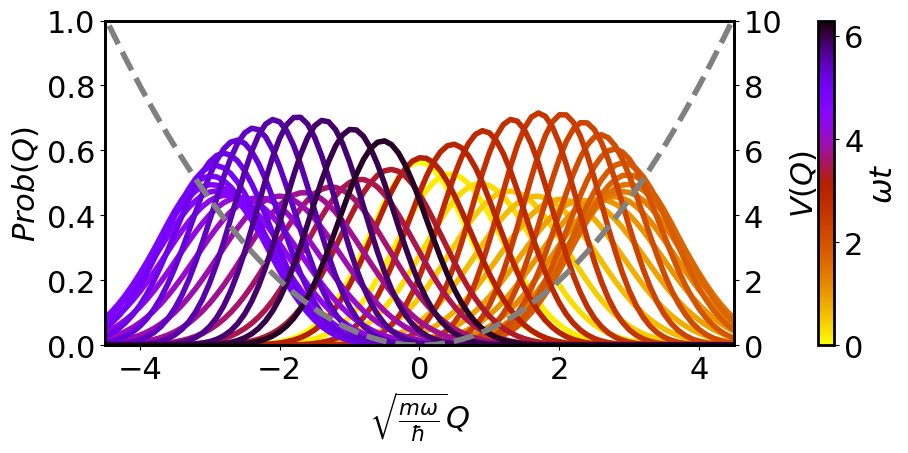

In [71]:
# for pra paper
kappa = 0.5
harmonic_cooled_Particle = evolvingParticle(
    kappa=kappa,
    p0=3,
    sx0=1 / np.sqrt(2),
    measurement=False,  # True, #
    feedback=False,  # True, #
    feedback_type="Cooling",
    tol=10,
    N_wait=150,
    tmax=2 * np.pi,
    Hamiltonian_type="Harmonic",
)

harmonic_cooled_Particle.timelapse(save=True)
# harmonic_cooled_Particle.plot_results(save = False)

Saving at: ./output/timelapse_density.png


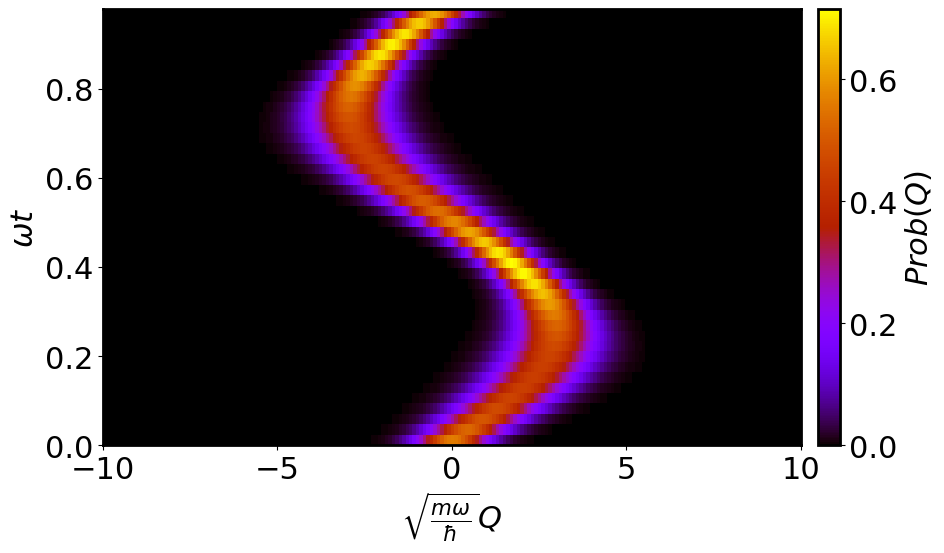

In [72]:
harmonic_cooled_Particle.timelapse_density(save=True)

## Example with numerical error checking

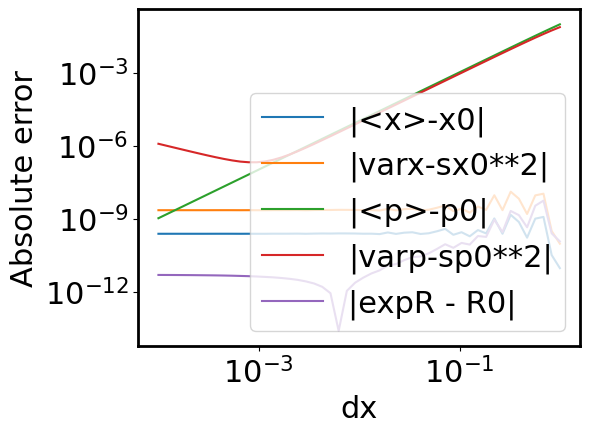

In [73]:
# Initial conditions
x0 = 1 / np.sqrt(2)
p0 = 1 / np.sqrt(2)
sx0 = 2 / np.sqrt(2)
R0 = 0

errors = []

DX = np.logspace(-4, 0, 50)
for dx in DX:
    # print(dx)
    myParticle = Particle(dx=dx, x0=x0, p0=p0, sx0=sx0, R0=R0, tol=10)
    # print(myParticle.error)
    errors.append(myParticle.error)
    del myParticle

plt.plot(DX, np.array(errors))
plt.xscale("log")
plt.yscale("log")
plt.xlabel("dx")
plt.ylabel("Absolute error")
plt.legend(["|<x>-x0|", "|varx-sx0**2|", "|<p>-p0|", "|varp-sp0**2|", "|expR - R0|"])
plt.show()

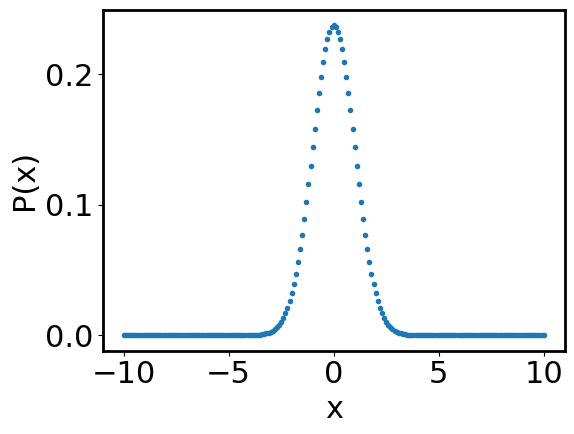

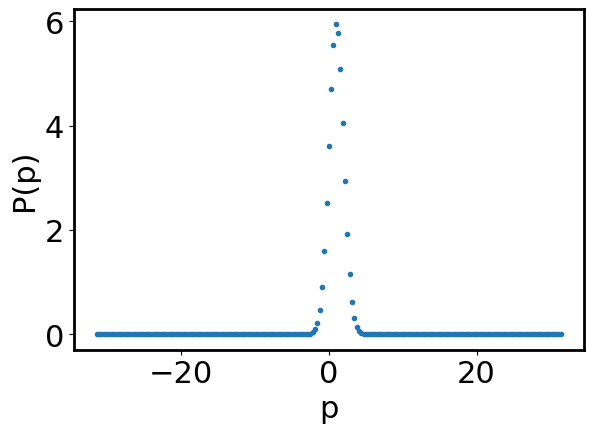

In [74]:
# Initial conditions
x0 = 0
p0 = 1
sx0 = 1 / np.sqrt(2)
R0 = 0

myParticle = Particle(
    dx=10**-1,
    x0=x0,
    p0=p0,
    sx0=sx0,
    R0=R0,
)

plt.plot(myParticle.x, abs((myParticle.psi)), ".")
plt.xlabel("x")
plt.ylabel("P(x)")
plt.show()

plt.plot(
    np.fft.fftfreq(myParticle.x.shape[-1]) * len(myParticle.x) * myParticle.dx * np.pi,
    abs(np.fft.fft(myParticle.psi)),
    ".",
)
# plt.xscale("log")
# plt.xlim([-4,4])
plt.xlabel("p")
plt.ylabel("P(p)")
plt.show()

In [75]:
del myParticle

## Example 1: Free particle cooled

In [76]:
kappa = 0.25

free_cooled_Particle = evolvingParticle(
    kappa=kappa,
    p0=4,
    x0=-7,
    measurement=False,
    feedback=False,
    feedback_type="Cooling",
    tol=10,
    tmax=0.4 * 2 * np.pi,
    Hamiltonian_type="Free",
)

Note that the measured observable x is assume to be position
Feedback coefficients c and d set to zero.


Theorectical: 2514it [00:00, 837195.73it/s]
Second order weak scheme: 100%|██████████| 2514/2514 [00:00<00:00, 4345.53it/s]


C:\Users\Amy\AppData\Local\Temp\ipykernel_33008\833532114.py:859: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-k" (-> color='k'). The keyword argument will take precedence.
  ax.plot(


./output/timelapse (1).png


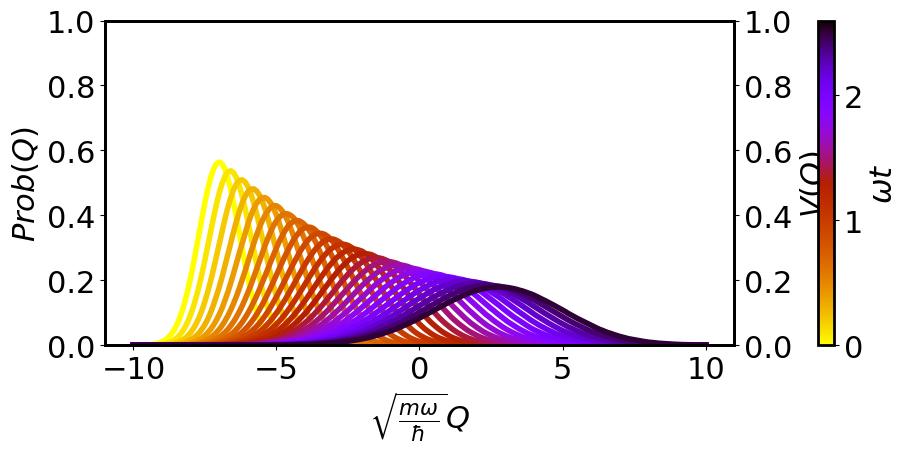

In [77]:
free_cooled_Particle.timelapse(save=True)

Saving at: ./output/timelapse_density (1).png


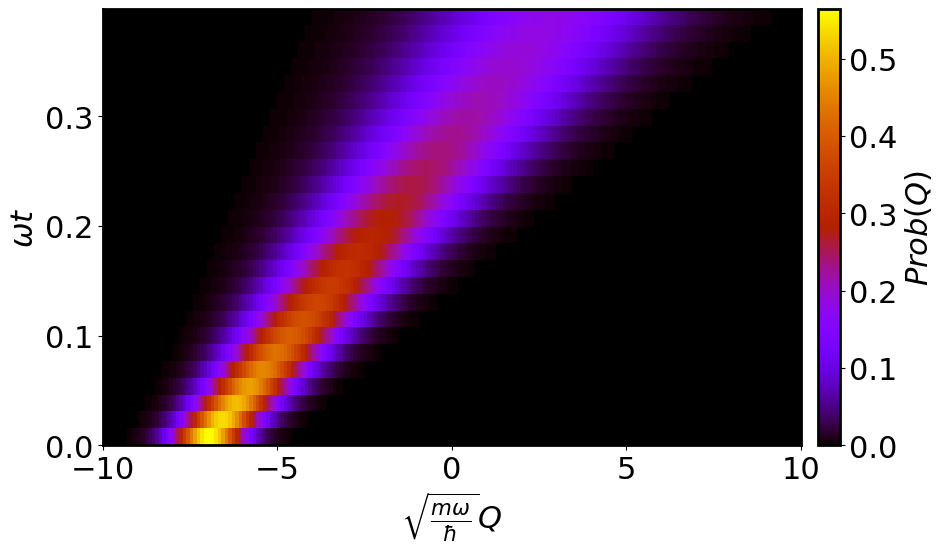

In [78]:
free_cooled_Particle.timelapse_density(save=True)

In [79]:
# free_cooled_Particle.plot_results(save = False)

In [80]:
# free_cooled_Particle.animate(save = True)

In [81]:
del free_cooled_Particle

## Example 2: Harmonic oscillator cooled

In [82]:
kappa = 0.5

Feedback coefficients c and d set to zero.


Second order weak scheme: 100%|██████████| 12567/12567 [00:03<00:00, 4182.61it/s]
C:\Users\Amy\AppData\Local\Temp\ipykernel_33008\833532114.py:859: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-k" (-> color='k'). The keyword argument will take precedence.
  ax.plot(


./output/timelapse (2).png


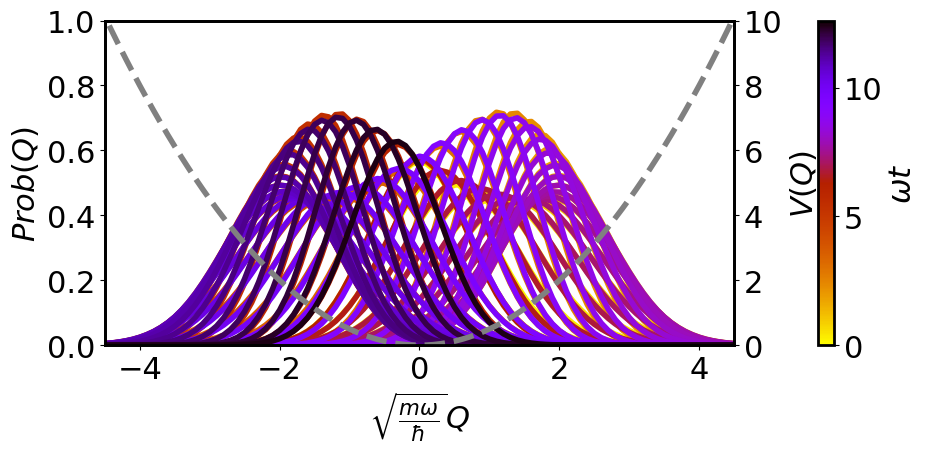

In [83]:
harmonic_cooled_Particle = evolvingParticle(
    kappa=kappa,
    p0=2,
    sx0=1 / np.sqrt(2),
    measurement=False,
    feedback=False,
    tol=10,
    N_wait=150,
    tmax=4 * np.pi,
    Hamiltonian_type="Harmonic",
)

harmonic_cooled_Particle.timelapse(save=True)

Saving at: ./output/timelapse_density (2).png


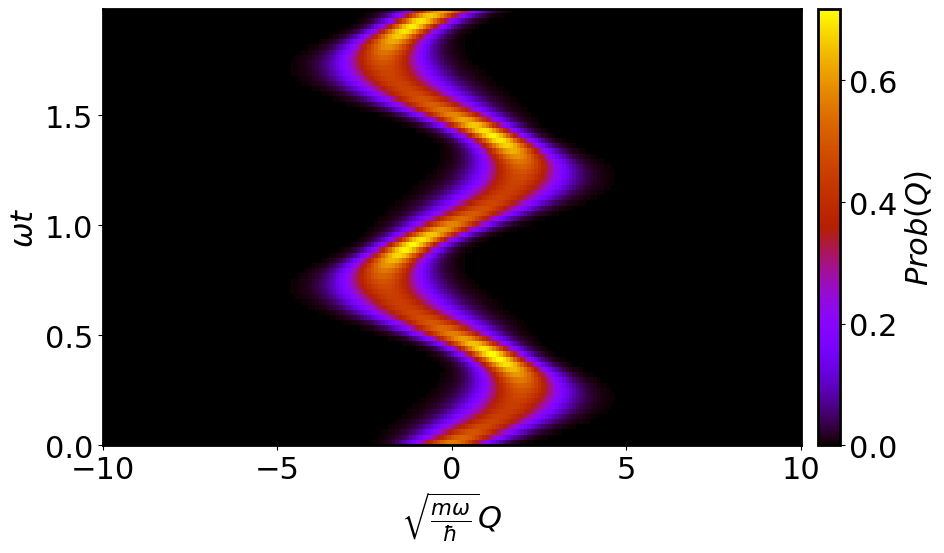

In [84]:
harmonic_cooled_Particle.timelapse_density(save=True)

In [85]:
# harmonic_cooled_Particle.animate(save = True)

In [86]:
del harmonic_cooled_Particle

Feedback coefficients c and d set to zero.


Second order weak scheme: 100%|██████████| 12567/12567 [00:03<00:00, 3301.50it/s]
C:\Users\Amy\AppData\Local\Temp\ipykernel_33008\833532114.py:859: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-k" (-> color='k'). The keyword argument will take precedence.
  ax.plot(


./output/timelapse (3).png


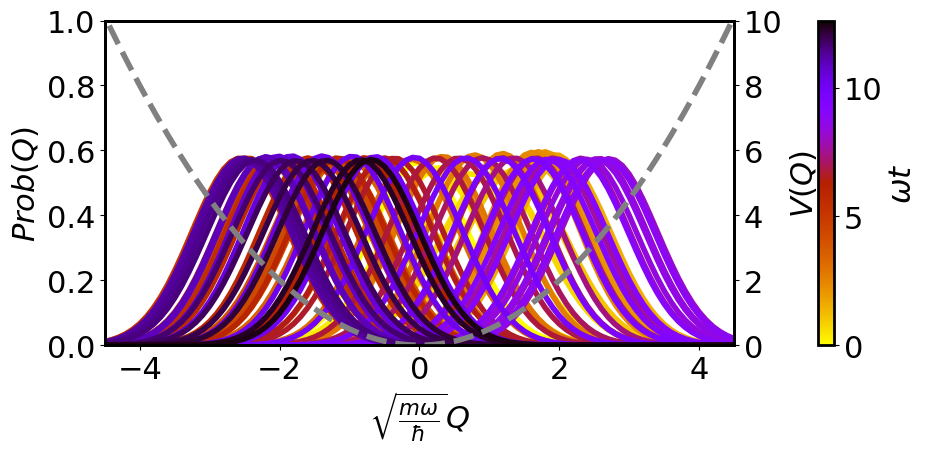

In [87]:
harmonic_cooled_Particle = evolvingParticle(
    kappa=kappa,
    p0=2,
    sx0=1 / np.sqrt(2),
    measurement=True,
    feedback=False,
    tol=10,
    N_wait=150,
    tmax=4 * np.pi,
    Hamiltonian_type="Harmonic",
)

harmonic_cooled_Particle.timelapse(save=True)

Saving at: ./output/timelapse_density (3).png


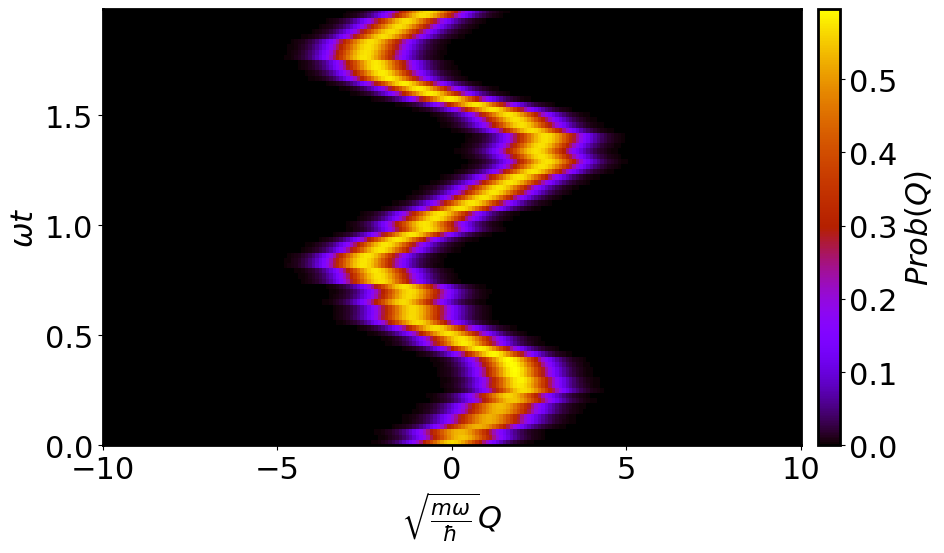

In [88]:
harmonic_cooled_Particle.timelapse_density(save=True)

In [89]:
# harmonic_cooled_Particle.animate(save = True)

In [90]:
del harmonic_cooled_Particle

Feedback coefficients c and d set to values for cooling.


Second order weak scheme: 100%|██████████| 12567/12567 [00:08<00:00, 1404.60it/s]
C:\Users\Amy\AppData\Local\Temp\ipykernel_33008\833532114.py:859: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-k" (-> color='k'). The keyword argument will take precedence.
  ax.plot(


./output/timelapse (4).png


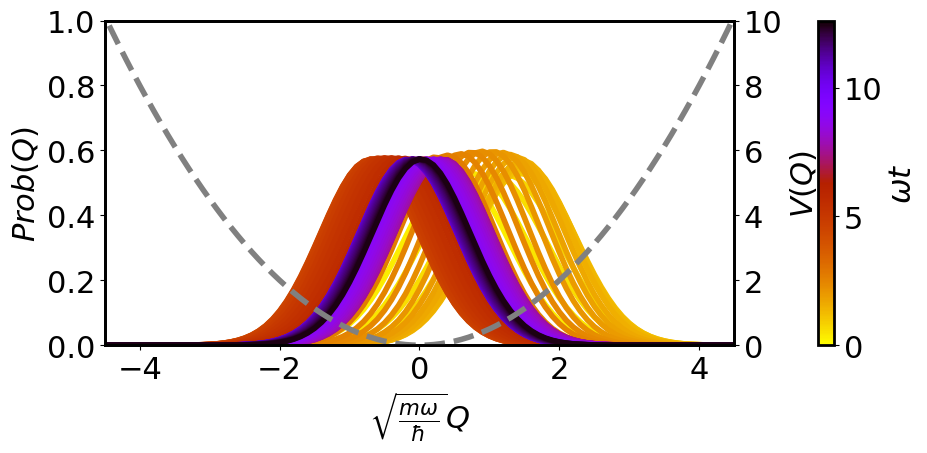

In [91]:
harmonic_cooled_Particle = evolvingParticle(
    kappa=kappa,
    p0=2,
    sx0=1 / np.sqrt(2),
    measurement=True,
    feedback=True,
    feedback_type="Cooling",
    tol=10,
    N_wait=150,
    tmax=4 * np.pi,
    Hamiltonian_type="Harmonic",
)

harmonic_cooled_Particle.timelapse(save=True)
# harmonic_cooled_Particle.plot_results(save = False)

Saving at: ./output/timelapse_density (4).png


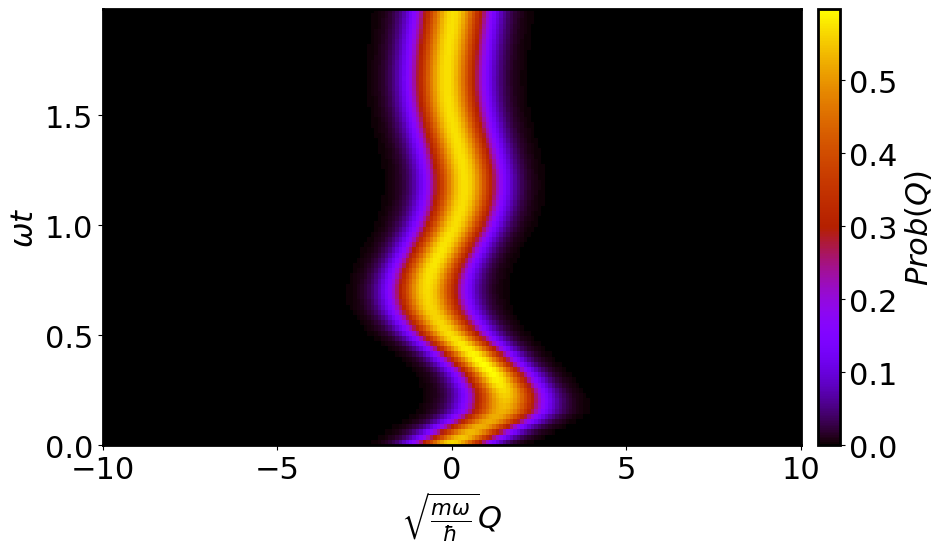

In [92]:
harmonic_cooled_Particle.timelapse_density(save=True)

In [93]:
# harmonic_cooled_Particle.animate(save = True)

In [94]:
del harmonic_cooled_Particle

# Example 3: double well

Feedback coefficients c and d set to zero.


Second order weak scheme: 100%|██████████| 15708/15708 [00:05<00:00, 2835.60it/s]
C:\Users\Amy\AppData\Local\Temp\ipykernel_33008\833532114.py:859: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-k" (-> color='k'). The keyword argument will take precedence.
  ax.plot(


./output/timelapse (5).png


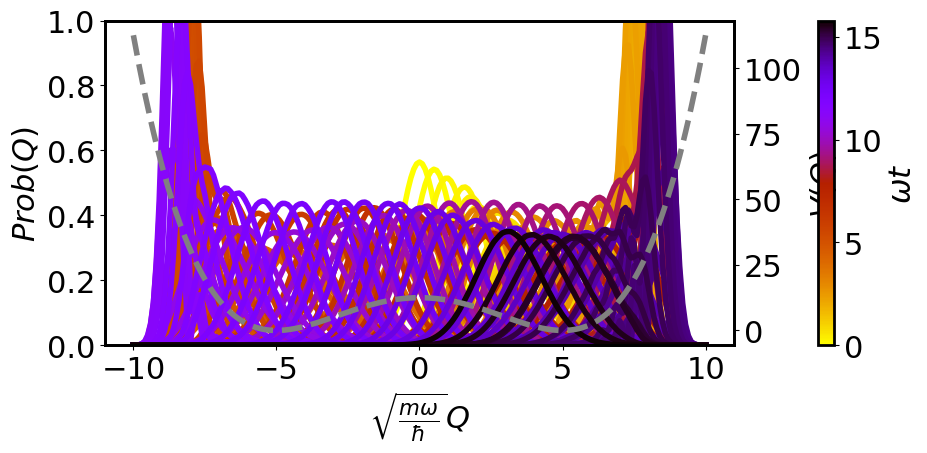

In [95]:
kappa = 0.25
myParticle = evolvingParticle(
    kappa=kappa,
    x0=0,
    p0=4,
    measurement=True,
    feedback=False,
    tmax=2.5 * 2 * np.pi,
    c=(-1 + np.sqrt(1 + kappa**2)),
    d=-2 * np.sqrt(-1 + np.sqrt(1 + kappa**2)) / np.sqrt(2),
    tol=10,
    Hamiltonian_type="DoubleWell",
)

myParticle.timelapse(save=True)
# myParticle.plot_results(save = False)

In [96]:
# myParticle.animate(save = True)

Saving at: ./output/timelapse_density (5).png


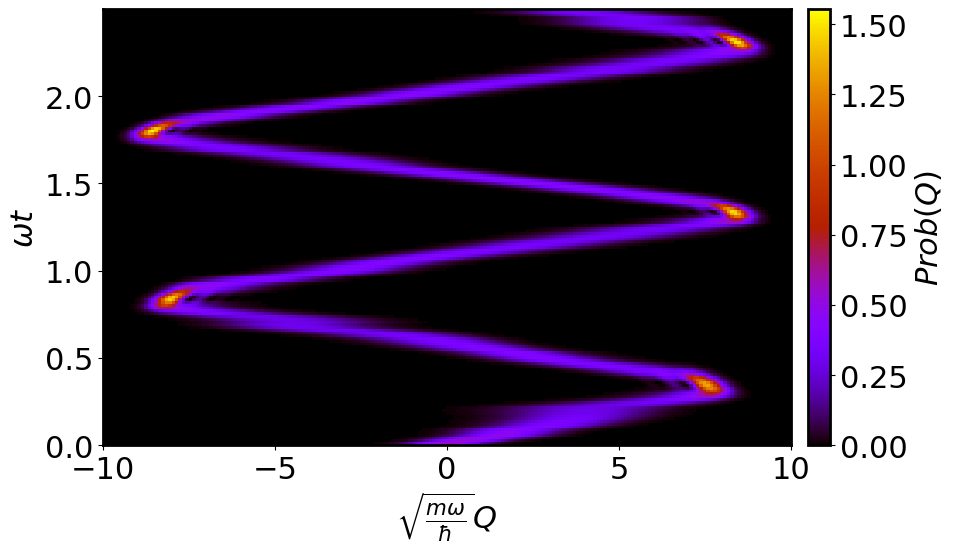

In [97]:
myParticle.timelapse_density(save=True)

In [98]:
del myParticle

## Compare effects of measurement and feedback

In [99]:
# kappa = 0.5
# hamiltonian_type = "Free"
# x0 = -5
# p0 = 1.5
# sx0 = 1/np.sqrt(2)
# tmax = 0.7*2*np.pi
# feedback_type = "Cooling"

# kappa = 0.5
# hamiltonian_type = "Harmonic"
# # x0 = 0
# p0 = 2  # 3
# sx0 = 1 / np.sqrt(2)  # 2 / np.sqrt(2)
# tmax = 4 * 2 * np.pi
# feedback_type = "Cooling"

kappa = 0.5
hamiltonian_type = "DoubleWell"
# x0 = 0
p0 = 2
sx0 = 1 / np.sqrt(2)
tmax = 5 * 2 * np.pi
feedback_type = "Cooling"

print("No measurement, no feedback")
P1 = evolvingParticle(
    kappa=kappa,
    # x0=x0,
    p0=p0,
    sx0=sx0,
    # R0=0,
    tol=10,
    tmax=tmax,
    measurement=False,
    feedback=False,
    Hamiltonian_type=hamiltonian_type,
)

print("Measurement but no feedback")
P2 = evolvingParticle(
    kappa=kappa,
    # x0=x0,
    p0=p0,
    sx0=sx0,
    # R0=0,
    tol=10,
    tmax=tmax,
    measurement=True,
    feedback=False,
    Hamiltonian_type=hamiltonian_type,
)

print("Measurement and feedback")
P3 = evolvingParticle(
    kappa=kappa,
    # x0=x0,
    p0=p0,
    sx0=sx0,
    # R0=0,
    tol=10,
    tmax=tmax,
    measurement=True,
    feedback=True,
    feedback_type=feedback_type,
    Hamiltonian_type=hamiltonian_type,
)

save = True

No measurement, no feedback
Feedback coefficients c and d set to zero.


Second order weak scheme: 100%|██████████| 31416/31416 [00:08<00:00, 3578.41it/s]


Measurement but no feedback
Feedback coefficients c and d set to zero.


Second order weak scheme: 100%|██████████| 31416/31416 [00:10<00:00, 2890.99it/s]


Measurement and feedback
Feedback coefficients c and d set to values for cooling.


Second order weak scheme: 100%|██████████| 31416/31416 [00:23<00:00, 1311.02it/s]


Saving at: ./output/animation_DoubleWell.gif


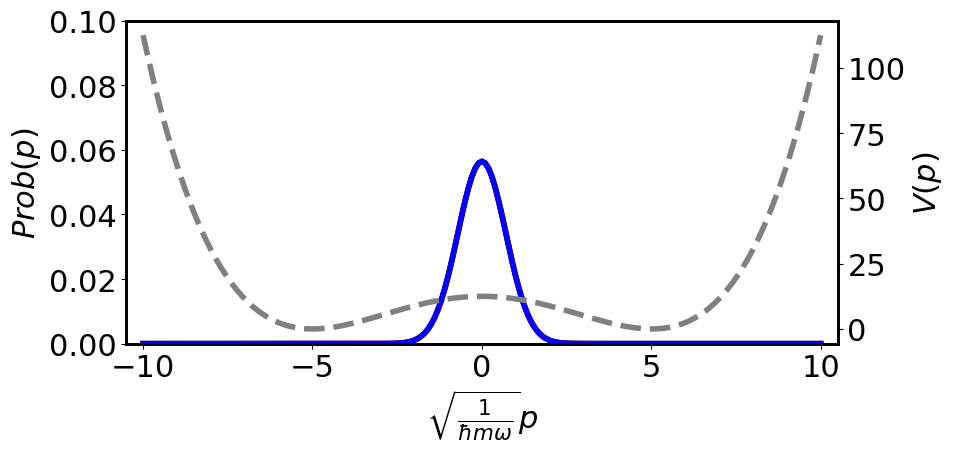

In [100]:
x = P1.x

fig, ax = plt.subplots(figsize=(10, 5))
ax2 = ax.twinx()


def frame(w):
    ax.clear()
    ax2.clear()

    ax.yaxis.set_tick_params(right=False)
    ax.yaxis.tick_left()
    ax2.yaxis.set_label_position("right")
    ax2.yaxis.set_ticks_position("right")
    ax2.set_ylabel(r"$V(p)$")

    ax.set_xlabel(r"$\sqrt{\frac{1}{\hbar m\omega}} p$")
    ax.set_ylabel(r"$Prob(p)$")

    psi_1 = P1.PSI[w]
    psi_2 = P2.PSI[w]
    psi_3 = P3.PSI[w]
    ax.plot(x, abs(psi_1) ** 2, "-k", linewidth=4)
    ax.plot(x, abs(psi_2) ** 2, "-r", linewidth=4)
    ax.plot(x, abs(psi_3) ** 2, "-b", linewidth=4)

    ax.set_ylim(top=0.1, bottom=0)
    # ax.set_xlim(left=-5.5, right=5.5)
    ax.set_xlim(left=-10.5, right=10.5)

    if P1.Hamiltonian_type == "Harmonic":
        ax2.plot(x, x**2 / 2, "--", color="grey", linewidth=4)
        ax2.set_ylim(top=10, bottom=0)
    elif P1.Hamiltonian_type == "DoubleWell":
        ax2.plot(
            x,
            -(x**2) + 1 / 50 * x**4 - min(-(x**2) + 1 / 50 * x**4),
            "--",
            color="grey",
            linewidth=4,
        )

    return plt.gca()


anim = animation.FuncAnimation(
    fig,
    frame,
    frames=len(P1.PSI),
    blit=False,
    repeat=True,
)
if save == True:
    fname = uniquify(f"./output/animation_{P1.Hamiltonian_type}.gif")
    print("Saving at:", fname)
    anim.save(
        fname, dpi=100, writer="pillow", fps=60, savefig_kwargs={"bbox_inches": "tight"}
    )

Saving at: ./output/animation_DoubleWell (1).gif


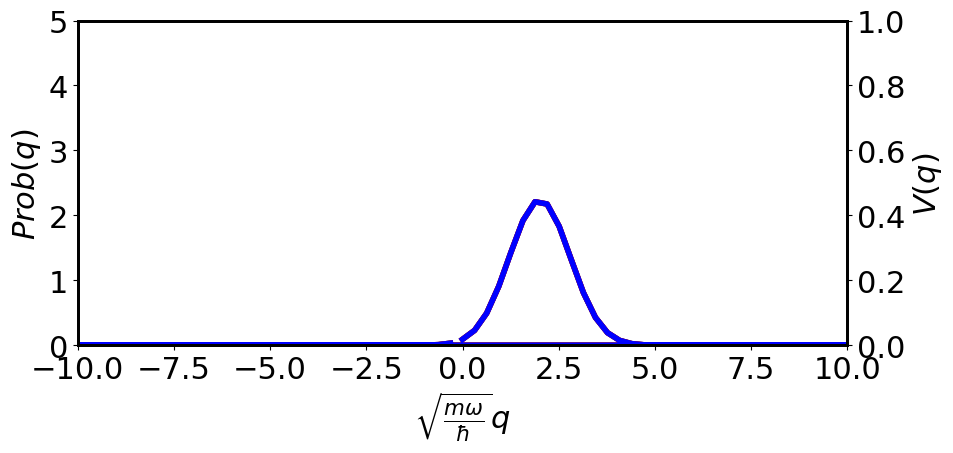

In [101]:
x = P1.x
dx = P1.dx
p = np.fft.fftfreq(x.shape[-1]) * len(x) * dx * np.pi

fig, ax = plt.subplots(figsize=(10, 5))
ax2 = ax.twinx()


def frame(w):
    ax.clear()
    ax2.clear()

    ax.yaxis.set_tick_params(right=False)
    ax.yaxis.tick_left()
    ax2.yaxis.set_label_position("right")
    ax2.yaxis.set_ticks_position("right")
    ax2.set_ylabel(r"$V(q)$")

    ax.set_xlabel(r"$\sqrt{\frac{m\omega}{\hbar}} q$")
    ax.set_ylabel(r"$Prob(q)$")

    psi_1 = np.fft.fft(P1.PSI[w])
    psi_2 = np.fft.fft(P2.PSI[w])
    psi_3 = np.fft.fft(P3.PSI[w])

    ax.plot(p, abs(psi_1) ** 2 / np.sqrt(sum(abs(psi_1) ** 2)), "-k", linewidth=4)
    ax.plot(p, abs(psi_2) ** 2 / np.sqrt(sum(abs(psi_1) ** 2)), "-r", linewidth=4)
    ax.plot(p, abs(psi_3) ** 2 / np.sqrt(sum(abs(psi_1) ** 2)), "-b", linewidth=4)

    ax.set_ylim(top=5, bottom=0)
    ax.set_xlim(left=-10, right=10)

    if P1.Hamiltonian_type == "Harmonic":
        ax2.plot(p, p**2 / 2, "--", color="grey", linewidth=4)
        ax2.set_ylim(top=10, bottom=0)

    return plt.gca()


anim = animation.FuncAnimation(
    fig,
    frame,
    frames=len(P1.PSI),
    blit=False,
    repeat=True,
)
if save == True:
    fname = uniquify(f"./output/animation_{P1.Hamiltonian_type}.gif")
    print("Saving at:", fname)
    anim.save(
        fname, dpi=100, writer="pillow", fps=60, savefig_kwargs={"bbox_inches": "tight"}
    )

In [102]:
del P1, P2, P3

## Average over multiple runs

1 for 5


Second order weak scheme: 100%|██████████| 9425/9425 [00:07<00:00, 1313.50it/s]


2 for 5


Second order weak scheme: 100%|██████████| 9425/9425 [00:07<00:00, 1312.65it/s]


3 for 5


Second order weak scheme: 100%|██████████| 9425/9425 [00:07<00:00, 1312.90it/s]


4 for 5


Second order weak scheme: 100%|██████████| 9425/9425 [00:07<00:00, 1300.16it/s]


5 for 5


Second order weak scheme: 100%|██████████| 9425/9425 [00:07<00:00, 1305.77it/s]
C:\Users\Amy\AppData\Local\Temp\ipykernel_33008\3318996264.py:126: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax4.legend(frameon=False, fontsize=18)
C:\Users\Amy\AppData\Local\Temp\ipykernel_33008\3318996264.py:129: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig1.savefig(
C:\Users\Amy\AppData\Local\Temp\ipykernel_33008\3318996264.py:136: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig2.savefig(
C:\Users\Amy\AppData\Local\Temp\ipykernel_33008\3318996264.py:143: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig4.savefig(
c:\Users\Amy\Desktop\Green_Git\measurement-based-feedb

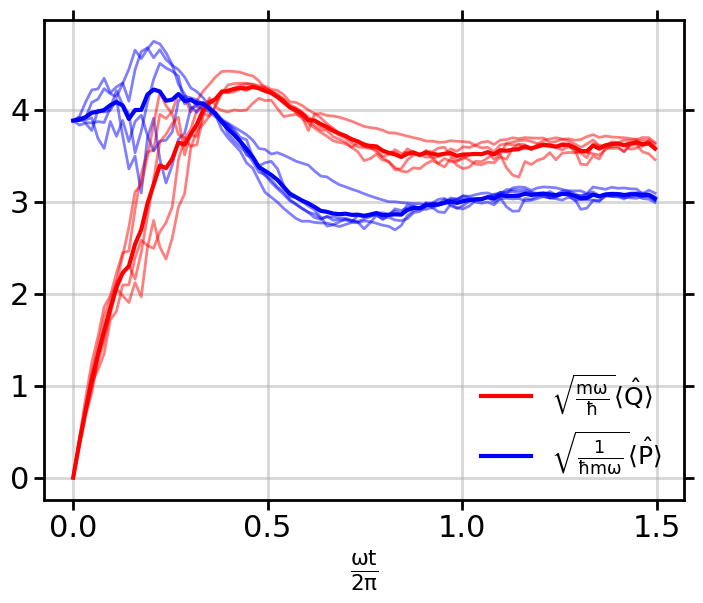

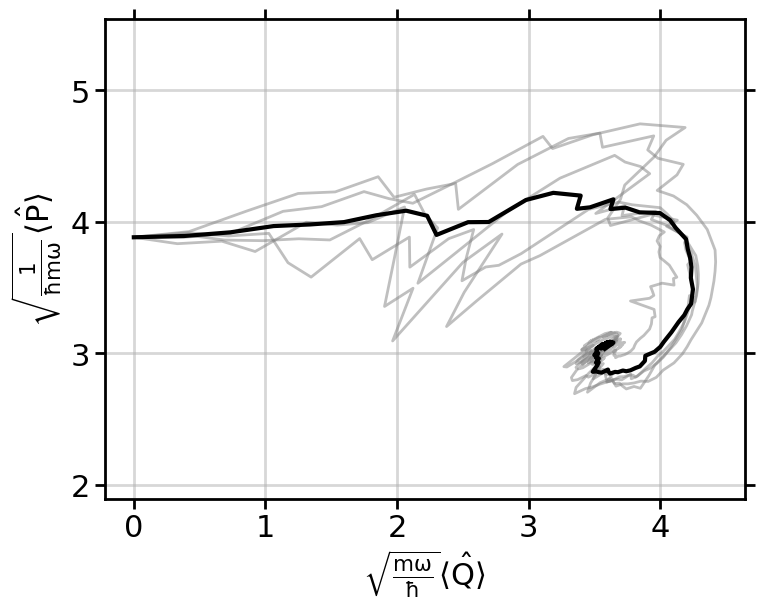

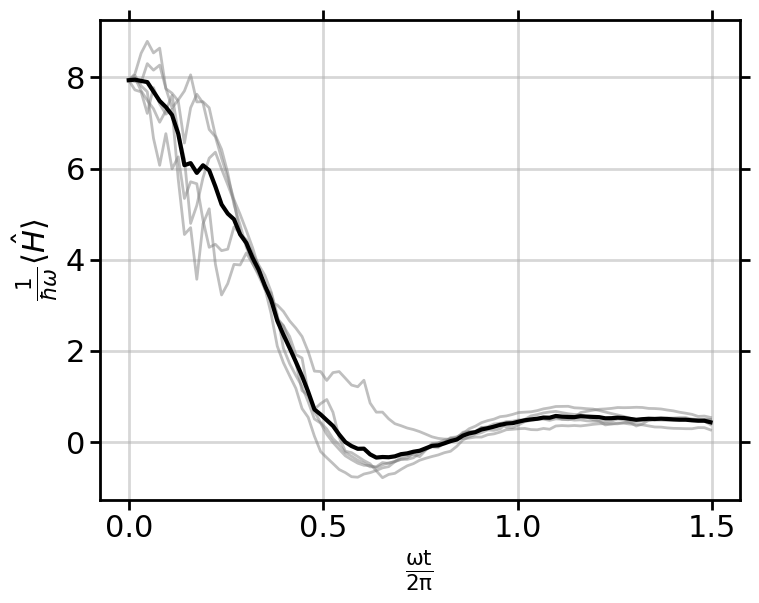

In [103]:
save = True

N_runs = 5  # 100
kappa = 1  # 0.25 #

fig1 = plt.figure()
ax1 = fig1.add_axes([0, 0, 1, 1])

fig2 = plt.figure()
ax2 = fig2.add_axes([0, 0, 1, 1])

fig4 = plt.figure()
ax4 = fig4.add_axes([0, 0, 1, 1])

X = 0
P = 0
E = 0

###############################

for i in range(N_runs):
    print(f"{i+1} for {N_runs}")
    # myParticle = evolvingParticle(kappa = kappa,
    #                     tol = 10,
    #                     measurement = True,
    #                     feedback = True,
    #                     feedback_type = "Cooling",
    #                     Hamiltonian_type = "Free") #"Harmonic"

    myParticle = evolvingParticle(
        kappa=kappa,
        x0=0,
        p0=4,
        measurement=True,
        feedback=True,
        tmax=1.5 * 2 * np.pi,
        c=(-1 + np.sqrt(1 + kappa**2)),
        d=-2 * np.sqrt(-1 + np.sqrt(1 + kappa**2)) / np.sqrt(2),
        tol=10,
        Hamiltonian_type="DoubleWell",
    )

    T = myParticle.T
    if i == 0:
        X = np.array(myParticle.EXP_X)
        P = np.array(myParticle.EXP_P)
        E = np.array(np.real(myParticle.E))
    else:
        X += np.array(myParticle.EXP_X)
        P += np.array(myParticle.EXP_P)
        E += np.array(np.real(myParticle.E))

    # if i < 10:
    ax1.plot(myParticle.T, myParticle.EXP_X, "-r", linewidth=2, alpha=0.5)

    ax1.plot(myParticle.T, myParticle.EXP_P, "-b", linewidth=2, alpha=0.5)

    ax2.plot(
        myParticle.EXP_X, myParticle.EXP_P, "-", linewidth=2, color="grey", alpha=0.5
    )

    ax4.plot(
        myParticle.T, np.real(myParticle.E), "-", linewidth=2, color="grey", alpha=0.5
    )

    del myParticle

X = np.array(X) / N_runs
P = np.array(P) / N_runs
E = np.array(E) / N_runs

ax4.plot(T, E, "-k", linewidth=3)  # ,label = r'$\mathregular{E}$')
ax2.plot(X, P, "-k", linewidth=3)
ax1.plot(
    T,
    X,
    "-r",
    linewidth=3,
    label=r"$\mathregular{\sqrt{\frac{m\omega}{\hbar}}\langle \hat{Q} \rangle}$",
)
ax1.plot(
    T,
    P,
    "-b",
    linewidth=3,
    label=r"$\mathregular{\sqrt{\frac{1}{\hbar m\omega}}\langle \hat{P} \rangle}$",
)


####################################
# ax.semilogx
ax1.xaxis.set_tick_params(which="major", size=7, width=2, direction="out", top="on")
ax1.xaxis.set_tick_params(which="minor", size=5, width=2, direction="out", top="on")
ax1.yaxis.set_tick_params(which="major", size=7, width=2, direction="out", right="on")
ax1.yaxis.set_tick_params(which="minor", size=5, width=2, direction="out", right="on")
ax1.grid(visible=True, which="major", axis="both", linewidth=2, alpha=0.5)
ax1.set_xlabel(r"$\mathregular{\frac{\omega t}{2\pi}}$")
ax1.legend(frameon=False, fontsize=18)


################################

ax2.xaxis.set_tick_params(which="major", size=7, width=2, direction="out", top="on")
ax2.xaxis.set_tick_params(which="minor", size=5, width=2, direction="out", top="on")
ax2.yaxis.set_tick_params(which="major", size=7, width=2, direction="out", right="on")
ax2.yaxis.set_tick_params(which="minor", size=5, width=2, direction="out", right="on")
ax2.grid(visible=True, which="major", axis="both", linewidth=2, alpha=0.5)
# ax.set_xlabel(r'$\mathregular{\frac{\omega t}{2\pi}}$')
ax2.set_xlabel(r"$\mathregular{\sqrt{\frac{m\omega}{\hbar}}\langle \hat{Q}\rangle}$")
ax2.set_ylabel(r"$\mathregular{\sqrt{\frac{1}{\hbar m\omega}}\langle \hat{P}\rangle}$")
ax2.axis("equal")

# ax2.set_xlim(-0.6, 0.6)
# ax2.set_ylim(-0.5, 0.5)


##################################

ax4.xaxis.set_tick_params(which="major", size=7, width=2, direction="out", top="on")
ax4.xaxis.set_tick_params(which="minor", size=5, width=2, direction="out", top="on")
ax4.yaxis.set_tick_params(which="major", size=7, width=2, direction="out", right="on")
ax4.yaxis.set_tick_params(which="minor", size=5, width=2, direction="out", right="on")
ax4.grid(visible=True, which="major", axis="both", linewidth=2, alpha=0.5)
ax4.set_xlabel(r"$\mathregular{\frac{\omega t}{2\pi}}$")
ax4.set_ylabel(r"$\frac{1}{\hbar\omega}\langle\hat{H} \rangle$")
ax4.legend(frameon=False, fontsize=18)

if save == True:
    fig1.savefig(
        uniquify("./output/figure_2_2.png"),
        dpi=300,
        transparent=False,
        bbox_inches="tight",
    )

    fig2.savefig(
        uniquify("./output/figure_2_3a.png"),
        dpi=300,
        transparent=False,
        bbox_inches="tight",
    )

    fig4.savefig(
        uniquify("./output/figure_2_5.png"),
        dpi=300,
        transparent=False,
        bbox_inches="tight",
    )

plt.show()